In [49]:
# -*- coding: utf-8 -*-
 
###################################################################
# On démarre ici 
###################################################################
#Chargement des bibliothèques générales utiles
import numpy as np #pour les vecteurs et tableaux notamment
import matplotlib.pyplot as plt  #pour les graphiques
#import scipy as sp  #pour l'analyse statistique
import pandas as pd  #pour les Dataframes ou tableaux de données
#import seaborn as sns #graphiques étendues
#import math #notamment pour sqrt()
import os
 
# Machine Learning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
import xgboost
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
 
#pour les scores
from sklearn.metrics import f1_score
#from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score
#ROC Curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
print(os.getcwd())  #verif
#mon répertoire sur ma machine - nécessaire quand on fait tourner le programme 
#par morceaux dans Spyder.
#myPath = "C:/Users/Pierre/MyPath"
#os.chdir(myPath) #modification du path
#print(os.getcwd()) #verif

/home/malick/Bureau/Stage_Projet_RTS/usecase/x(g)boost


In [39]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

file_diabetes = "/home/malick/Bureau/Stage_Projet_RTS/usecase/x(g)boost/diabetes.csv"
file_house = "/home/malick/Bureau/Stage_Projet_RTS/usecase/x(g)boost/house_data.csv"

train_df = pd.read_csv(file_diabetes)
#Col_obj = list(df.select_dtypes(include='object').columns)
#df[Col_obj] =df[Col_obj].astype(str) 


In [22]:
train_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [29]:
#Split data into training features and labels
X, y = train_df.loc[:, train_df.columns != 'Outcome'], train_df['Outcome']

# split data into train and test sets
seed = 7
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [34]:
#instantiate model and train
myXGBoost = XGBClassifier(learning_rate = 0.05, n_estimators=200, max_depth=3)
eval_set = [(X_test, y_test)]
myXGBoost.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=True)

# make predictions for test set
y_pred = myXGBoost.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-logloss:0.676098
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.660325
[2]	validation_0-logloss:0.646265
[3]	validation_0-logloss:0.633494
[4]	validation_0-logloss:0.621636
[5]	validation_0-logloss:0.611272
[6]	validation_0-logloss:0.60132
[7]	validation_0-logloss:0.592098
[8]	validation_0-logloss:0.584276
[9]	validation_0-logloss:0.57616
[10]	validation_0-logloss:0.569238
[11]	validation_0-logloss:0.562529
[12]	validation_0-logloss:0.5558
[13]	validation_0-logloss:0.549673
[14]	validation_0-logloss:0.544048
[15]	validation_0-logloss:0.538694
[16]	validation_0-logloss:0.534496
[17]	validation_0-logloss:0.530106
[18]	validation_0-logloss:0.526299
[19]	validation_0-logloss:0.522601
[20]	validation_0-logloss:0.518788
[21]	validation_0-logloss:0.516614
[22]	validation_0-logloss:0.513641
[23]	validation_0-logloss:0.51083
[24]	validation_0-logloss:0.507727
[25]	validation_0-logloss:0.505971
[26]	validation_0-logloss:0.504533
[2

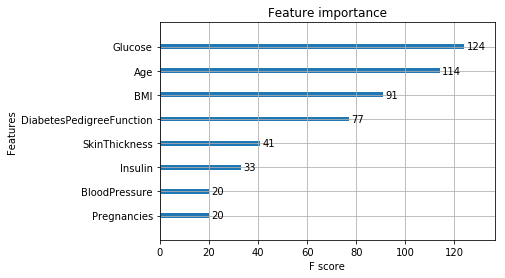

In [35]:
# plot feature importance
plot_importance(myXGBoost)
plt.show()

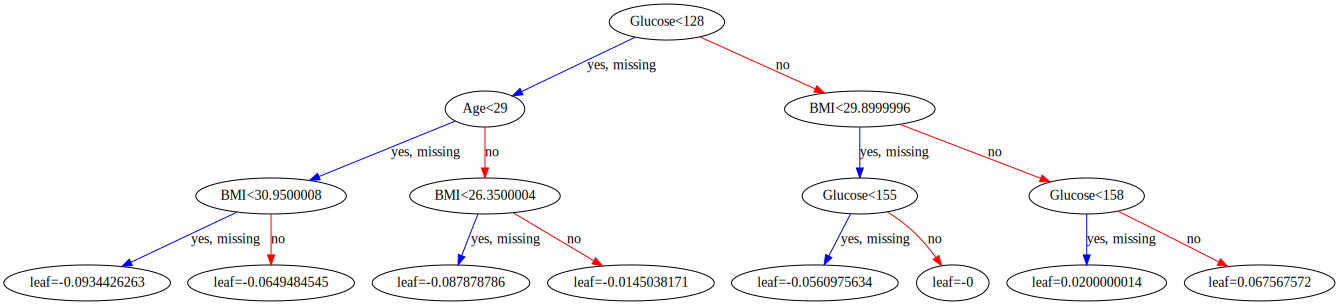

In [36]:
xgboost.to_graphviz(myXGBoost, num_trees=0)

In [41]:
####Optimisation des hyper paramètres XGBoost via un Algorithme Génétique

In [42]:
#parametres par défaut    
myXGBoost.get_xgb_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.05,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 200,
 'nthread': 1,
 'objective': 'binary:logistic',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 0,
 'subsample': 1,
 'verbosity': 1}

In [43]:
###########################################################################
# réglage fin des paramètres de XGBClassifier
# On va utiliser un algorithme génétique pour rechercher des meilleurs 
# paramètres de XGBCLassifier
# Modification du programme ga de Stephen Marsland  
# inspiré aussi de mohit jain  
# passage de xgb.train en XGBClassifier
# Remarque : 'n_estimators'  n'est pas pris en compte dans xgb.train()
###########################################################################
 
 
###########################  Fonction de Fitness utilisée ici 
#La fonction d'évaluation est basée sur le  F1_score    
#on calcule le F1 score pour chaque XGBClassifier
def train_populationClassifier(population, X, y, X_train, X_test, y_train, y_test):
    print("Fitness Function")
    f1Score = []
    for i in range(population.shape[0]):
        print("Fitness Boucle dans la population "+str(i))
        param = { 'objective':'binary:logistic',
              'learning_rate': population[i][0],
              'n_estimators': int(population[i][1]), 
              'max_depth': int(population[i][2]), 
              'min_child_weight': population[i][3],
              'gamma': population[i][4], 
              'subsample': population[i][5],
              'colsample_bytree': population[i][6],
              'seed': 24}
        
        myXGBClassifier = XGBClassifier(**param).fit(X_train,y_train)
        preds=myXGBClassifier.predict(X_Scaled)
        preds = preds>0.5
        f1Score.append(round((f1_score(y,  preds, average='weighted')), 4))
    return f1Score
###### / fonction de Fitness

In [54]:
######################################################################
#on utilise  ga_XGBClassifier - Attention cela dure un moment !!!!
###################################################################"

iterations=20  #nombre de générations
import ga_XGBClassifier #import de la classe
#on instancie un objet de classe ga_XGBClassifier
myGA = ga_XGBClassifier.ga_XGBClassifier(train_populationClassifier,
                                       nEpochs=iterations, X=X_Scaled, y=y,
                                       X_train=X_train, X_test=X_test, 
                                       y_train=y_train, y_test=y_test, 
                                       populationSize=100,
                                       crossover='un',nElite=4,tournamentOK=True)
myGA.runGA()  #on boucle dans l'objet créé


myGA.bestParams #meileurs parametres par génération
myGA.bestfit   #meileur fitness par génération
nMax=myGA.bestfit.size

ca tourne
boucle génération = 0
Fitness Function
Fitness Boucle dans la population 0


/home/malick/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fitness Boucle dans la population 1
Fitness Boucle dans la population 2
Fitness Boucle dans la population 3
Fitness Boucle dans la population 4
Fitness Boucle dans la population 5
Fitness Boucle dans la population 6
Fitness Boucle dans la population 7
Fitness Boucle dans la population 8
Fitness Boucle dans la population 9
Fitness Boucle dans la population 10
Fitness Boucle dans la population 11
Fitness Boucle dans la population 12
Fitness Boucle dans la population 13
Fitness Boucle dans la population 14
Fitness Boucle dans la population 15
Fitness Boucle dans la population 16
Fitness Boucle dans la population 17
Fitness Boucle dans la population 18
Fitness Boucle dans la population 19
Fitness Boucle dans la population 20
Fitness Boucle dans la population 21
Fitness Boucle dans la population 22
Fitness Boucle dans la population 23
Fitness Boucle dans la population 24
Fitness Boucle dans la population 25
Fitness Boucle dans la population 26
Fitness Boucle dans la population 27
Fitness Bo

Add multiple copies i =  53
Avec fitness :  10.0
Add multiple copies i =  54
Avec fitness :  10.0
Add multiple copies i =  55
Avec fitness :  10.0
Add multiple copies i =  56
Avec fitness :  10.0
Add multiple copies i =  57
Avec fitness :  10.0
Add multiple copies i =  58
Avec fitness :  10.0
Add multiple copies i =  59
Avec fitness :  10.0
Add multiple copies i =  60
Avec fitness :  10.0
Add multiple copies i =  61
Avec fitness :  10.0
Add multiple copies i =  62
Avec fitness :  10.0
Add multiple copies i =  63
Avec fitness :  10.0
Add multiple copies i =  64
Avec fitness :  10.0
Add multiple copies i =  65
Avec fitness :  10.0
Add multiple copies i =  66
Avec fitness :  10.0
Add multiple copies i =  67
Avec fitness :  10.0
Add multiple copies i =  68
Avec fitness :  10.0
Add multiple copies i =  69
Avec fitness :  10.0
Add multiple copies i =  70
Avec fitness :  10.0
Add multiple copies i =  71
Avec fitness :  10.0
Add multiple copies i =  72
Avec fitness :  10.0
Add multiple copies 

Fitness Boucle dans la population 33
Fitness Boucle dans la population 34
Fitness Boucle dans la population 35
Fitness Boucle dans la population 36
Fitness Boucle dans la population 37
Fitness Boucle dans la population 38
Fitness Boucle dans la population 39
Fitness Boucle dans la population 40
Fitness Boucle dans la population 41
Fitness Boucle dans la population 42
Fitness Boucle dans la population 43
Fitness Boucle dans la population 44
Fitness Boucle dans la population 45
Fitness Boucle dans la population 46
Fitness Boucle dans la population 47
Fitness Boucle dans la population 48
Fitness Boucle dans la population 49
Fitness Boucle dans la population 50
Fitness Boucle dans la population 51
Fitness Boucle dans la population 52
Fitness Boucle dans la population 53
Fitness Boucle dans la population 54
Fitness Boucle dans la population 55
Fitness Boucle dans la population 56
Fitness Boucle dans la population 57
Fitness Boucle dans la population 58
Fitness Boucle dans la population 59
F

Fitness Boucle dans la population 1
Fitness Boucle dans la population 2
Fitness Boucle dans la population 3
Fitness Boucle dans la population 4
Fitness Boucle dans la population 5
Fitness Boucle dans la population 6
Fitness Boucle dans la population 7
Fitness Boucle dans la population 8
Fitness Boucle dans la population 9
Fitness Boucle dans la population 10
Fitness Boucle dans la population 11
Fitness Boucle dans la population 12
Fitness Boucle dans la population 13
Fitness Boucle dans la population 14
Fitness Boucle dans la population 15
Fitness Boucle dans la population 16
Fitness Boucle dans la population 17
Fitness Boucle dans la population 18
Fitness Boucle dans la population 19
Fitness Boucle dans la population 20
Fitness Boucle dans la population 21
Fitness Boucle dans la population 22
Fitness Boucle dans la population 23
Fitness Boucle dans la population 24
Fitness Boucle dans la population 25
Fitness Boucle dans la population 26
Fitness Boucle dans la population 27
Fitness Bo

Avec fitness :  10.0
Add multiple copies i =  24
Avec fitness :  10.0
Add multiple copies i =  25
Avec fitness :  10.0
Add multiple copies i =  26
Avec fitness :  10.0
Add multiple copies i =  27
Avec fitness :  10.0
Add multiple copies i =  28
Avec fitness :  10.0
Add multiple copies i =  29
Avec fitness :  10.0
Add multiple copies i =  30
Avec fitness :  10.0
Add multiple copies i =  31
Avec fitness :  10.0
Add multiple copies i =  32
Avec fitness :  10.0
Add multiple copies i =  33
Avec fitness :  10.0
Add multiple copies i =  34
Avec fitness :  10.0
Add multiple copies i =  35
Avec fitness :  10.0
Add multiple copies i =  36
Avec fitness :  10.0
Add multiple copies i =  37
Avec fitness :  10.0
Add multiple copies i =  38
Avec fitness :  10.0
Add multiple copies i =  39
Avec fitness :  10.0
Add multiple copies i =  40
Avec fitness :  10.0
Add multiple copies i =  41
Avec fitness :  10.0
Add multiple copies i =  42
Avec fitness :  10.0
Add multiple copies i =  43
Avec fitness :  10.0

Fitness Boucle dans la population 3
Fitness Boucle dans la population 4
Fitness Boucle dans la population 5
Fitness Boucle dans la population 6
Fitness Boucle dans la population 7
Fitness Boucle dans la population 8
Fitness Boucle dans la population 9
Fitness Boucle dans la population 10
Fitness Boucle dans la population 11
Fitness Boucle dans la population 12
Fitness Boucle dans la population 13
Fitness Boucle dans la population 14
Fitness Boucle dans la population 15
Fitness Boucle dans la population 16
Fitness Boucle dans la population 17
Fitness Boucle dans la population 18
Fitness Boucle dans la population 19
Fitness Boucle dans la population 20
Fitness Boucle dans la population 21
Fitness Boucle dans la population 22
Fitness Boucle dans la population 23
Fitness Boucle dans la population 24
Fitness Boucle dans la population 25
Fitness Boucle dans la population 26
Fitness Boucle dans la population 27
Fitness Boucle dans la population 28
Fitness Boucle dans la population 29
Fitness 

Add multiple copies i =  74
Avec fitness :  10.0
Add multiple copies i =  75
Avec fitness :  10.0
Add multiple copies i =  76
Avec fitness :  10.0
Add multiple copies i =  77
Avec fitness :  10.0
Add multiple copies i =  78
Avec fitness :  10.0
Add multiple copies i =  79
Avec fitness :  10.0
Add multiple copies i =  80
Avec fitness :  10.0
Add multiple copies i =  81
Avec fitness :  10.0
Add multiple copies i =  82
Avec fitness :  10.0
Add multiple copies i =  83
Avec fitness :  10.0
Add multiple copies i =  84
Avec fitness :  10.0
Add multiple copies i =  85
Avec fitness :  10.0
Add multiple copies i =  86
Avec fitness :  10.0
Add multiple copies i =  87
Avec fitness :  10.0
Add multiple copies i =  88
Avec fitness :  10.0
Add multiple copies i =  89
Avec fitness :  10.0
Add multiple copies i =  90
Avec fitness :  10.0
Add multiple copies i =  91
Avec fitness :  10.0
Add multiple copies i =  92
Avec fitness :  10.0
Add multiple copies i =  93
Avec fitness :  10.0
Add multiple copies 

Fitness Boucle dans la population 61
Fitness Boucle dans la population 62
Fitness Boucle dans la population 63
Fitness Boucle dans la population 64
Fitness Boucle dans la population 65
Fitness Boucle dans la population 66
Fitness Boucle dans la population 67
Fitness Boucle dans la population 68
Fitness Boucle dans la population 69
Fitness Boucle dans la population 70
Fitness Boucle dans la population 71
Fitness Boucle dans la population 72
Fitness Boucle dans la population 73
Fitness Boucle dans la population 74
Fitness Boucle dans la population 75
Fitness Boucle dans la population 76
Fitness Boucle dans la population 77
Fitness Boucle dans la population 78
Fitness Boucle dans la population 79
Fitness Boucle dans la population 80
Fitness Boucle dans la population 81
Fitness Boucle dans la population 82
Fitness Boucle dans la population 83
Fitness Boucle dans la population 84
Fitness Boucle dans la population 85
Fitness Boucle dans la population 86
Fitness Boucle dans la population 87
F

Fitness Boucle dans la population 1
Fitness Boucle dans la population 2
Fitness Boucle dans la population 3
Fitness Boucle dans la population 4
Fitness Boucle dans la population 5
Fitness Boucle dans la population 6
Fitness Boucle dans la population 7
Fitness Boucle dans la population 8
Fitness Boucle dans la population 9
Fitness Boucle dans la population 10
Fitness Boucle dans la population 11
Fitness Boucle dans la population 12
Fitness Boucle dans la population 13
Fitness Boucle dans la population 14
Fitness Boucle dans la population 15
Fitness Boucle dans la population 16
Fitness Boucle dans la population 17
Fitness Boucle dans la population 18
Fitness Boucle dans la population 19
Fitness Boucle dans la population 20
Fitness Boucle dans la population 21
Fitness Boucle dans la population 22
Fitness Boucle dans la population 23
Fitness Boucle dans la population 24
Fitness Boucle dans la population 25
Fitness Boucle dans la population 26
Fitness Boucle dans la population 27
Fitness Bo

Liste des fitness pour cette génération  5 [0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134]
Meilleurs paramètres de cette génération  5 [5.80e-01 2.55e+02 1.10e+01 1.00e+01 3.66e+00 4.00e-01 1.00e-02]
Meilleur Fitness de cette génération  5 0.5134


Fitness Boucle dans la population 26
Fitness Boucle dans la population 27
Fitness Boucle dans la population 28
Fitness Boucle dans la population 29
Fitness Boucle dans la population 30
Fitness Boucle dans la population 31
Fitness Boucle dans la population 32
Fitness Boucle dans la population 33
Fitness Boucle dans la population 34
Fitness Boucle dans la population 35
Fitness Boucle dans la population 36
Fitness Boucle dans la population 37
Fitness Boucle dans la population 38
Fitness Boucle dans la population 39
Fitness Boucle dans la population 40
Fitness Boucle dans la population 41
Fitness Boucle dans la population 42
Fitness Boucle dans la population 43
Fitness Boucle dans la population 44
Fitness Boucle dans la population 45
Fitness Boucle dans la population 46
Fitness Boucle dans la population 47
Fitness Boucle dans la population 48
Fitness Boucle dans la population 49
Fitness Boucle dans la population 50
Fitness Boucle dans la population 51
Fitness Boucle dans la population 52
F

Add multiple copies i =  39
Avec fitness :  10.0
Add multiple copies i =  40
Avec fitness :  10.0
Add multiple copies i =  41
Avec fitness :  10.0
Add multiple copies i =  42
Avec fitness :  10.0
Add multiple copies i =  43
Avec fitness :  10.0
Add multiple copies i =  44
Avec fitness :  10.0
Add multiple copies i =  45
Avec fitness :  10.0
Add multiple copies i =  46
Avec fitness :  10.0
Add multiple copies i =  47
Avec fitness :  10.0
Add multiple copies i =  48
Avec fitness :  10.0
Add multiple copies i =  49
Avec fitness :  10.0
Add multiple copies i =  50
Avec fitness :  10.0
Add multiple copies i =  51
Avec fitness :  10.0
Add multiple copies i =  52
Avec fitness :  10.0
Add multiple copies i =  53
Avec fitness :  10.0
Add multiple copies i =  54
Avec fitness :  10.0
Add multiple copies i =  55
Avec fitness :  10.0
Add multiple copies i =  56
Avec fitness :  10.0
Add multiple copies i =  57
Avec fitness :  10.0
Add multiple copies i =  58
Avec fitness :  10.0
Add multiple copies 

Fitness Boucle dans la population 17
Fitness Boucle dans la population 18
Fitness Boucle dans la population 19
Fitness Boucle dans la population 20
Fitness Boucle dans la population 21
Fitness Boucle dans la population 22
Fitness Boucle dans la population 23
Fitness Boucle dans la population 24
Fitness Boucle dans la population 25
Fitness Boucle dans la population 26
Fitness Boucle dans la population 27
Fitness Boucle dans la population 28
Fitness Boucle dans la population 29
Fitness Boucle dans la population 30
Fitness Boucle dans la population 31
Fitness Boucle dans la population 32
Fitness Boucle dans la population 33
Fitness Boucle dans la population 34
Fitness Boucle dans la population 35
Fitness Boucle dans la population 36
Fitness Boucle dans la population 37
Fitness Boucle dans la population 38
Fitness Boucle dans la population 39
Fitness Boucle dans la population 40
Fitness Boucle dans la population 41
Fitness Boucle dans la population 42
Fitness Boucle dans la population 43
F

Add multiple copies i =  92
Avec fitness :  10.0
Add multiple copies i =  93
Avec fitness :  10.0
Add multiple copies i =  94
Avec fitness :  10.0
Add multiple copies i =  95
Avec fitness :  10.0
Add multiple copies i =  96
Avec fitness :  10.0
Add multiple copies i =  97
Avec fitness :  10.0
Add multiple copies i =  98
Avec fitness :  10.0
Add multiple copies i =  99
Avec fitness :  10.0
Uniform crossover
Mutation Paramètre sélectionné : [2]
Elitisme
Début de Tournoi
Fitness Function
Fitness Boucle dans la population 0
Fitness Boucle dans la population 1
Fitness Boucle dans la population 2
Fitness Boucle dans la population 3
Fitness Boucle dans la population 4
Fitness Boucle dans la population 5
Fitness Boucle dans la population 6
Fitness Boucle dans la population 7
Fitness Boucle dans la population 8
Fitness Boucle dans la population 9
Fitness Boucle dans la population 10
Fitness Boucle dans la population 11
Fitness Boucle dans la population 12
Fitness Boucle dans la population 13
Fi

Fitness Boucle dans la population 85
Fitness Boucle dans la population 86
Fitness Boucle dans la population 87
Fitness Boucle dans la population 88
Fitness Boucle dans la population 89
Fitness Boucle dans la population 90
Fitness Boucle dans la population 91
Fitness Boucle dans la population 92
Fitness Boucle dans la population 93
Fitness Boucle dans la population 94
Fitness Boucle dans la population 95
Fitness Boucle dans la population 96
Fitness Boucle dans la population 97
Fitness Boucle dans la population 98
Fitness Boucle dans la population 99
Liste des fitness pour cette génération  8 [0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0

Fitness Boucle dans la population 13
Fitness Boucle dans la population 14
Fitness Boucle dans la population 15
Fitness Boucle dans la population 16
Fitness Boucle dans la population 17
Fitness Boucle dans la population 18
Fitness Boucle dans la population 19
Fitness Boucle dans la population 20
Fitness Boucle dans la population 21
Fitness Boucle dans la population 22
Fitness Boucle dans la population 23
Fitness Boucle dans la population 24
Fitness Boucle dans la population 25
Fitness Boucle dans la population 26
Fitness Boucle dans la population 27
Fitness Boucle dans la population 28
Fitness Boucle dans la population 29
Fitness Boucle dans la population 30
Fitness Boucle dans la population 31
Fitness Boucle dans la population 32
Fitness Boucle dans la population 33
Fitness Boucle dans la population 34
Fitness Boucle dans la population 35
Fitness Boucle dans la population 36
Fitness Boucle dans la population 37
Fitness Boucle dans la population 38
Fitness Boucle dans la population 39
F

Add multiple copies i =  21
Avec fitness :  10.0
Add multiple copies i =  22
Avec fitness :  10.0
Add multiple copies i =  23
Avec fitness :  10.0
Add multiple copies i =  24
Avec fitness :  10.0
Add multiple copies i =  25
Avec fitness :  10.0
Add multiple copies i =  26
Avec fitness :  10.0
Add multiple copies i =  27
Avec fitness :  10.0
Add multiple copies i =  28
Avec fitness :  10.0
Add multiple copies i =  29
Avec fitness :  10.0
Add multiple copies i =  30
Avec fitness :  10.0
Add multiple copies i =  31
Avec fitness :  10.0
Add multiple copies i =  32
Avec fitness :  10.0
Add multiple copies i =  33
Avec fitness :  10.0
Add multiple copies i =  34
Avec fitness :  10.0
Add multiple copies i =  35
Avec fitness :  10.0
Add multiple copies i =  36
Avec fitness :  10.0
Add multiple copies i =  37
Avec fitness :  10.0
Add multiple copies i =  38
Avec fitness :  10.0
Add multiple copies i =  39
Avec fitness :  10.0
Add multiple copies i =  40
Avec fitness :  10.0
Add multiple copies 

Fitness Boucle dans la population 5
Fitness Boucle dans la population 6
Fitness Boucle dans la population 7
Fitness Boucle dans la population 8
Fitness Boucle dans la population 9
Fitness Boucle dans la population 10
Fitness Boucle dans la population 11
Fitness Boucle dans la population 12
Fitness Boucle dans la population 13
Fitness Boucle dans la population 14
Fitness Boucle dans la population 15
Fitness Boucle dans la population 16
Fitness Boucle dans la population 17
Fitness Boucle dans la population 18
Fitness Boucle dans la population 19
Fitness Boucle dans la population 20
Fitness Boucle dans la population 21
Fitness Boucle dans la population 22
Fitness Boucle dans la population 23
Fitness Boucle dans la population 24
Fitness Boucle dans la population 25
Fitness Boucle dans la population 26
Fitness Boucle dans la population 27
Fitness Boucle dans la population 28
Fitness Boucle dans la population 29
Fitness Boucle dans la population 30
Fitness Boucle dans la population 31
Fitnes

Mutation Paramètre sélectionné : [4]
Elitisme
Début de Tournoi
Fitness Function
Fitness Boucle dans la population 0
Fitness Boucle dans la population 1
Fitness Boucle dans la population 2
Fitness Boucle dans la population 3
Fitness Boucle dans la population 4
Fitness Boucle dans la population 5
Fitness Boucle dans la population 6
Fitness Boucle dans la population 7
Fitness Boucle dans la population 8
Fitness Boucle dans la population 9
Fitness Boucle dans la population 10
Fitness Boucle dans la population 11
Fitness Boucle dans la population 12
Fitness Boucle dans la population 13
Fitness Boucle dans la population 14
Fitness Boucle dans la population 15
Fitness Boucle dans la population 16
Fitness Boucle dans la population 17
Fitness Boucle dans la population 18
Fitness Boucle dans la population 19
Fitness Boucle dans la population 20
Fitness Boucle dans la population 21
Fitness Boucle dans la population 22
Fitness Boucle dans la population 23
Fitness Boucle dans la population 24
Fitne

Liste des fitness pour cette génération  11 [0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134]
Meilleurs paramètres de cette génération  11 [ 0.55 10.    9.   10.    9.24  0.35  0.01]
Meilleur Fitness de cette génération  11 0.5134
Recupération des p

Fitness Boucle dans la population 33
Fitness Boucle dans la population 34
Fitness Boucle dans la population 35
Fitness Boucle dans la population 36
Fitness Boucle dans la population 37
Fitness Boucle dans la population 38
Fitness Boucle dans la population 39
Fitness Boucle dans la population 40
Fitness Boucle dans la population 41
Fitness Boucle dans la population 42
Fitness Boucle dans la population 43
Fitness Boucle dans la population 44
Fitness Boucle dans la population 45
Fitness Boucle dans la population 46
Fitness Boucle dans la population 47
Fitness Boucle dans la population 48
Fitness Boucle dans la population 49
Fitness Boucle dans la population 50
Fitness Boucle dans la population 51
Fitness Boucle dans la population 52
Fitness Boucle dans la population 53
Fitness Boucle dans la population 54
Fitness Boucle dans la population 55
Fitness Boucle dans la population 56
Fitness Boucle dans la population 57
Fitness Boucle dans la population 58
Fitness Boucle dans la population 59
F

Add multiple copies i =  59
Avec fitness :  10.0
Add multiple copies i =  60
Avec fitness :  10.0
Add multiple copies i =  61
Avec fitness :  10.0
Add multiple copies i =  62
Avec fitness :  10.0
Add multiple copies i =  63
Avec fitness :  10.0
Add multiple copies i =  64
Avec fitness :  10.0
Add multiple copies i =  65
Avec fitness :  10.0
Add multiple copies i =  66
Avec fitness :  10.0
Add multiple copies i =  67
Avec fitness :  10.0
Add multiple copies i =  68
Avec fitness :  10.0
Add multiple copies i =  69
Avec fitness :  10.0
Add multiple copies i =  70
Avec fitness :  10.0
Add multiple copies i =  71
Avec fitness :  10.0
Add multiple copies i =  72
Avec fitness :  10.0
Add multiple copies i =  73
Avec fitness :  10.0
Add multiple copies i =  74
Avec fitness :  10.0
Add multiple copies i =  75
Avec fitness :  10.0
Add multiple copies i =  76
Avec fitness :  10.0
Add multiple copies i =  77
Avec fitness :  10.0
Add multiple copies i =  78
Avec fitness :  10.0
Add multiple copies 

Fitness Boucle dans la population 42
Fitness Boucle dans la population 43
Fitness Boucle dans la population 44
Fitness Boucle dans la population 45
Fitness Boucle dans la population 46
Fitness Boucle dans la population 47
Fitness Boucle dans la population 48
Fitness Boucle dans la population 49
Fitness Boucle dans la population 50
Fitness Boucle dans la population 51
Fitness Boucle dans la population 52
Fitness Boucle dans la population 53
Fitness Boucle dans la population 54
Fitness Boucle dans la population 55
Fitness Boucle dans la population 56
Fitness Boucle dans la population 57
Fitness Boucle dans la population 58
Fitness Boucle dans la population 59
Fitness Boucle dans la population 60
Fitness Boucle dans la population 61
Fitness Boucle dans la population 62
Fitness Boucle dans la population 63
Fitness Boucle dans la population 64
Fitness Boucle dans la population 65
Fitness Boucle dans la population 66
Fitness Boucle dans la population 67
Fitness Boucle dans la population 68
F

Add multiple copies i =  81
Avec fitness :  10.0
Add multiple copies i =  82
Avec fitness :  10.0
Add multiple copies i =  83
Avec fitness :  10.0
Add multiple copies i =  84
Avec fitness :  10.0
Add multiple copies i =  85
Avec fitness :  10.0
Add multiple copies i =  86
Avec fitness :  10.0
Add multiple copies i =  87
Avec fitness :  10.0
Add multiple copies i =  88
Avec fitness :  10.0
Add multiple copies i =  89
Avec fitness :  10.0
Add multiple copies i =  90
Avec fitness :  10.0
Add multiple copies i =  91
Avec fitness :  10.0
Add multiple copies i =  92
Avec fitness :  10.0
Add multiple copies i =  93
Avec fitness :  10.0
Add multiple copies i =  94
Avec fitness :  10.0
Add multiple copies i =  95
Avec fitness :  10.0
Add multiple copies i =  96
Avec fitness :  10.0
Add multiple copies i =  97
Avec fitness :  10.0
Add multiple copies i =  98
Avec fitness :  10.0
Add multiple copies i =  99
Avec fitness :  10.0
Uniform crossover
Mutation Paramètre sélectionné : [2]
Elitisme
Début

Fitness Boucle dans la population 74
Fitness Boucle dans la population 75
Fitness Boucle dans la population 76
Fitness Boucle dans la population 77
Fitness Boucle dans la population 78
Fitness Boucle dans la population 79
Fitness Boucle dans la population 80
Fitness Boucle dans la population 81
Fitness Boucle dans la population 82
Fitness Boucle dans la population 83
Fitness Boucle dans la population 84
Fitness Boucle dans la population 85
Fitness Boucle dans la population 86
Fitness Boucle dans la population 87
Fitness Boucle dans la population 88
Fitness Boucle dans la population 89
Fitness Boucle dans la population 90
Fitness Boucle dans la population 91
Fitness Boucle dans la population 92
Fitness Boucle dans la population 93
Fitness Boucle dans la population 94
Fitness Boucle dans la population 95
Fitness Boucle dans la population 96
Fitness Boucle dans la population 97
Fitness Boucle dans la population 98
Fitness Boucle dans la population 99
Liste des fitness pour cette génératio

Fitness Boucle dans la population 5
Fitness Boucle dans la population 6
Fitness Boucle dans la population 7
Fitness Boucle dans la population 8
Fitness Boucle dans la population 9
Fitness Boucle dans la population 10
Fitness Boucle dans la population 11
Fitness Boucle dans la population 12
Fitness Boucle dans la population 13
Fitness Boucle dans la population 14
Fitness Boucle dans la population 15
Fitness Boucle dans la population 16
Fitness Boucle dans la population 17
Fitness Boucle dans la population 18
Fitness Boucle dans la population 19
Fitness Boucle dans la population 20
Fitness Boucle dans la population 21
Fitness Boucle dans la population 22
Fitness Boucle dans la population 23
Fitness Boucle dans la population 24
Fitness Boucle dans la population 25
Fitness Boucle dans la population 26
Fitness Boucle dans la population 27
Fitness Boucle dans la population 28
Fitness Boucle dans la population 29
Fitness Boucle dans la population 30
Fitness Boucle dans la population 31
Fitnes

Add multiple copies i =  30
Avec fitness :  10.0
Add multiple copies i =  31
Avec fitness :  10.0
Add multiple copies i =  32
Avec fitness :  10.0
Add multiple copies i =  33
Avec fitness :  10.0
Add multiple copies i =  34
Avec fitness :  10.0
Add multiple copies i =  35
Avec fitness :  10.0
Add multiple copies i =  36
Avec fitness :  10.0
Add multiple copies i =  37
Avec fitness :  10.0
Add multiple copies i =  38
Avec fitness :  10.0
Add multiple copies i =  39
Avec fitness :  10.0
Add multiple copies i =  40
Avec fitness :  10.0
Add multiple copies i =  41
Avec fitness :  10.0
Add multiple copies i =  42
Avec fitness :  10.0
Add multiple copies i =  43
Avec fitness :  10.0
Add multiple copies i =  44
Avec fitness :  10.0
Add multiple copies i =  45
Avec fitness :  10.0
Add multiple copies i =  46
Avec fitness :  10.0
Add multiple copies i =  47
Avec fitness :  10.0
Add multiple copies i =  48
Avec fitness :  10.0
Add multiple copies i =  49
Avec fitness :  10.0
Add multiple copies 

Fitness Boucle dans la population 5
Fitness Boucle dans la population 6
Fitness Boucle dans la population 7
Fitness Boucle dans la population 8
Fitness Boucle dans la population 9
Fitness Boucle dans la population 10
Fitness Boucle dans la population 11
Fitness Boucle dans la population 12
Fitness Boucle dans la population 13
Fitness Boucle dans la population 14
Fitness Boucle dans la population 15
Fitness Boucle dans la population 16
Fitness Boucle dans la population 17
Fitness Boucle dans la population 18
Fitness Boucle dans la population 19
Fitness Boucle dans la population 20
Fitness Boucle dans la population 21
Fitness Boucle dans la population 22
Fitness Boucle dans la population 23
Fitness Boucle dans la population 24
Fitness Boucle dans la population 25
Fitness Boucle dans la population 26
Fitness Boucle dans la population 27
Fitness Boucle dans la population 28
Fitness Boucle dans la population 29
Fitness Boucle dans la population 30
Fitness Boucle dans la population 31
Fitnes

Elitisme
Début de Tournoi
Fitness Function
Fitness Boucle dans la population 0
Fitness Boucle dans la population 1
Fitness Boucle dans la population 2
Fitness Boucle dans la population 3
Fitness Boucle dans la population 4
Fitness Boucle dans la population 5
Fitness Boucle dans la population 6
Fitness Boucle dans la population 7
Fitness Boucle dans la population 8
Fitness Boucle dans la population 9
Fitness Boucle dans la population 10
Fitness Boucle dans la population 11
Fitness Boucle dans la population 12
Fitness Boucle dans la population 13
Fitness Boucle dans la population 14
Fitness Boucle dans la population 15
Fitness Boucle dans la population 16
Fitness Boucle dans la population 17
Fitness Boucle dans la population 18
Fitness Boucle dans la population 19
Fitness Boucle dans la population 20
Fitness Boucle dans la population 21
Fitness Boucle dans la population 22
Fitness Boucle dans la population 23
Fitness Boucle dans la population 24
Fitness Boucle dans la population 25
Fitne

Liste des fitness pour cette génération  17 [0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134, 0.5134]
Meilleurs paramètres de cette génération  17 [ 0.62 10.    7.   10.    5.74  0.2   0.13]
Meilleur Fitness de cette génération  17 0.5134
Recupération des p

Fitness Boucle dans la population 33
Fitness Boucle dans la population 34
Fitness Boucle dans la population 35
Fitness Boucle dans la population 36
Fitness Boucle dans la population 37
Fitness Boucle dans la population 38
Fitness Boucle dans la population 39
Fitness Boucle dans la population 40
Fitness Boucle dans la population 41
Fitness Boucle dans la population 42
Fitness Boucle dans la population 43
Fitness Boucle dans la population 44
Fitness Boucle dans la population 45
Fitness Boucle dans la population 46
Fitness Boucle dans la population 47
Fitness Boucle dans la population 48
Fitness Boucle dans la population 49
Fitness Boucle dans la population 50
Fitness Boucle dans la population 51
Fitness Boucle dans la population 52
Fitness Boucle dans la population 53
Fitness Boucle dans la population 54
Fitness Boucle dans la population 55
Fitness Boucle dans la population 56
Fitness Boucle dans la population 57
Fitness Boucle dans la population 58
Fitness Boucle dans la population 59
F

Add multiple copies i =  11
Avec fitness :  8.473345436540683
Add multiple copies i =  12
Avec fitness :  8.473345436540683
Add multiple copies i =  13
Avec fitness :  8.473345436540683
Add multiple copies i =  14
Avec fitness :  8.473345436540683
Add multiple copies i =  15
Avec fitness :  8.473345436540683
Add multiple copies i =  16
Avec fitness :  8.473345436540683
Add multiple copies i =  17
Avec fitness :  8.473345436540683
Add multiple copies i =  18
Avec fitness :  8.473345436540683
Add multiple copies i =  19
Avec fitness :  8.473345436540683
Add multiple copies i =  20
Avec fitness :  8.473345436540683
Add multiple copies i =  21
Avec fitness :  8.473345436540683
Add multiple copies i =  22
Avec fitness :  8.473345436540683
Add multiple copies i =  23
Avec fitness :  8.473345436540683
Add multiple copies i =  24
Avec fitness :  8.473345436540683
Add multiple copies i =  25
Avec fitness :  8.473345436540683
Add multiple copies i =  26
Avec fitness :  8.473345436540683
Add mult

Fitness Boucle dans la population 71
Fitness Boucle dans la population 72
Fitness Boucle dans la population 73
Fitness Boucle dans la population 74
Fitness Boucle dans la population 75
Fitness Boucle dans la population 76
Fitness Boucle dans la population 77
Fitness Boucle dans la population 78
Fitness Boucle dans la population 79
Fitness Boucle dans la population 80
Fitness Boucle dans la population 81
Fitness Boucle dans la population 82
Fitness Boucle dans la population 83
Fitness Boucle dans la population 84
Fitness Boucle dans la population 85
Fitness Boucle dans la population 86
Fitness Boucle dans la population 87
Fitness Boucle dans la population 88
Fitness Boucle dans la population 89
Fitness Boucle dans la population 90
Fitness Boucle dans la population 91
Fitness Boucle dans la population 92
Fitness Boucle dans la population 93
Fitness Boucle dans la population 94
Fitness Boucle dans la population 95
Fitness Boucle dans la population 96
Fitness Boucle dans la population 97
F

Add multiple copies i =  53
Avec fitness :  8.413634873811866
Add multiple copies i =  54
Avec fitness :  8.413634873811866
Add multiple copies i =  55
Avec fitness :  9.970501474926255
Add multiple copies i =  56
Avec fitness :  8.413634873811866
Add multiple copies i =  57
Avec fitness :  8.413634873811866
Add multiple copies i =  58
Avec fitness :  8.413634873811866
Add multiple copies i =  59
Avec fitness :  8.413634873811866
Add multiple copies i =  60
Avec fitness :  8.413634873811866
Add multiple copies i =  61
Avec fitness :  9.954113405440841
Add multiple copies i =  62
Avec fitness :  9.962307440183547
Add multiple copies i =  63
Avec fitness :  8.413634873811866
Add multiple copies i =  64
Avec fitness :  8.413634873811866
Add multiple copies i =  65
Avec fitness :  8.413634873811866
Add multiple copies i =  66
Avec fitness :  8.45296624057686
Add multiple copies i =  67
Avec fitness :  8.413634873811866
Add multiple copies i =  68
Avec fitness :  9.823008849557523
Add multi

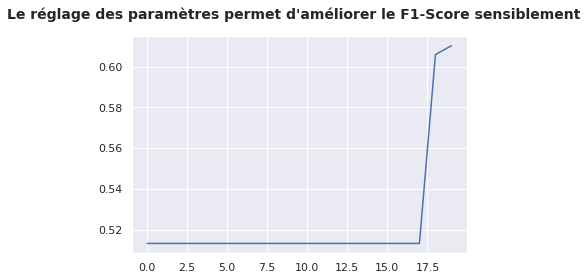

In [55]:
###########################################################  
#Graphique Evolution des meilleurs F1 Scores
sns.set()  #paramètres esthétiques ressemble à ggplot par défaut.
fig, ax = plt.subplots()  #un seul plot
sns.lineplot(x=np.arange(0,nMax), y=myGA.bestfit[0:nMax])
fig.suptitle("Le réglage des paramètres permet d'améliorer le F1-Score sensiblement", fontsize=14, fontweight='bold')
#ax.set(xlabel='generation', ylabel='F1 Score',
#       title="Le F1 score passe de "+"{0:.3f}".format(baseF1Score)+" à "+"{0:.3f}".format(myGA.bestfit[nMax-1]) )
#ax.xaxis.set_ticks(range(nMax))
#fig.text(.3,-.06,"Evolution des meilleurs f1 Scores \n Recherche des meilleurs paramètres XGBoost", 
#         fontsize=9)
plt.show()
fig.savefig("QPPS6-GA-XGBClassifier-BestF1Scores.png", bbox_inches="tight", dpi=600)
##########################################################################
# MERCI pour votre attention !
##########################################################################
#on reste dans l'IDE
#if __name__ == '__main__':
#  main()

In [59]:
import pickle

# save model to file
pickle.dump(myXGBoost, open("model_XGBoost", "wb"))

In [60]:
# load model from file
loaded_model = pickle.load(open("model_XGBoost", "rb"))

In [66]:
# make predictions for test data
y_pred = loaded_model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

KeyError: 0

In [65]:
#parametres par défaut    
loaded_model.get_xgb_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.05,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': nan,
 'n_estimators': 200,
 'nthread': 1,
 'objective': 'binary:logistic',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 0,
 'subsample': 1,
 'verbosity': 1}